Bagging与随机森林之三
===

# 6.使用随机森林进行回归预测

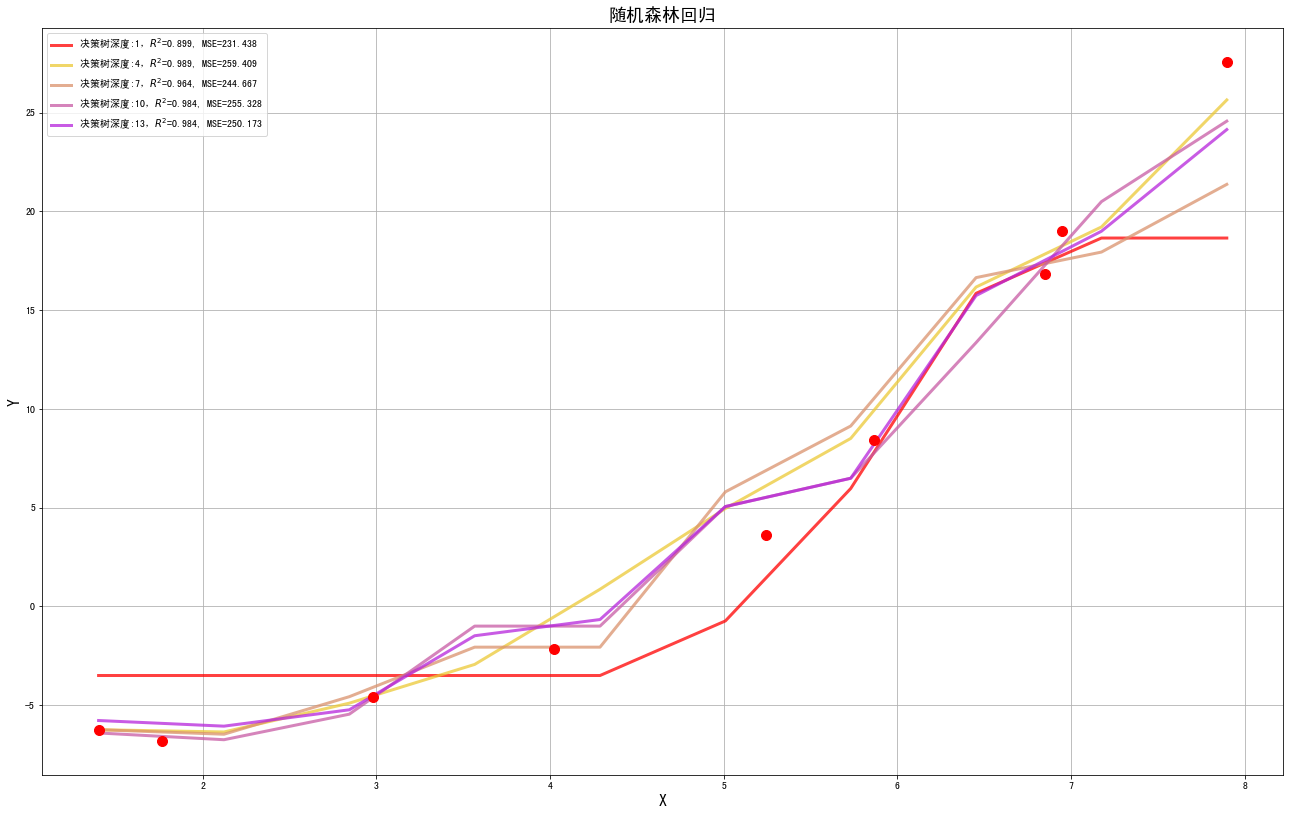

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
import matplotlib as mpl

np.random.seed(0)
np.set_printoptions(linewidth=1000)
N = 9

x = np.asarray([1.40015721,1.76405235,2.97873798,4.02272212,5.2408932,5.86755799,6.84864279,6.95008842,7.89678115], dtype=np.float)
y = np.asarray([-6.22959012,-6.80028513,-4.58779845,-2.1475575,3.62506375,8.40186804,16.84301125,18.99745441,27.56686965])

x.shape = -1, 1
y.shape = -1, 1

mpl.rcParams['font.sans-serif'] = [u'SimHei']  # 黑体 FangSong/KaiTi
mpl.rcParams['axes.unicode_minus'] = False

deep_length = 15
model = RandomForestRegressor(n_estimators=10)
clrs = []  # 颜色
for c in np.linspace(16711680, 255, deep_length):
    clrs.append("#{:06X}".format(int(c), 2))
d_pool = np.arange(1, deep_length + 1, 3)  # 阶

label = '随机森林回归'

plt.figure(figsize=(18, 12), facecolor='w')
plt.plot(x, y, 'ro', ms=10, zorder=N)

for i, d in enumerate(d_pool):
    model.set_params(max_depth=d)
    model.fit(x, y.ravel())

    x_hat = np.linspace(x.min(), x.max(), num=10)
    x_hat.shape = -1, 1
    y_hat = model.predict(x_hat)
    s = model.score(x, y)
    mse = np.average((y_hat - np.array(y)) ** 2)# 误差平方和
    label1 = u'决策树深度:%d，$R^2$=%.3f, MSE=%.3f' % (d, s, mse)
    plt.plot(x_hat, y_hat, color=clrs[i], lw=3, alpha=0.75, label=label1)

plt.legend(loc='upper left')
plt.grid(True)
plt.title(label, fontsize=18)
plt.xlabel('X', fontsize=16)
plt.ylabel('Y', fontsize=16)

plt.tight_layout(1, rect=(0, 0, 1, 0.95))

# 7.比较决策树、Bagging算法和随机森林

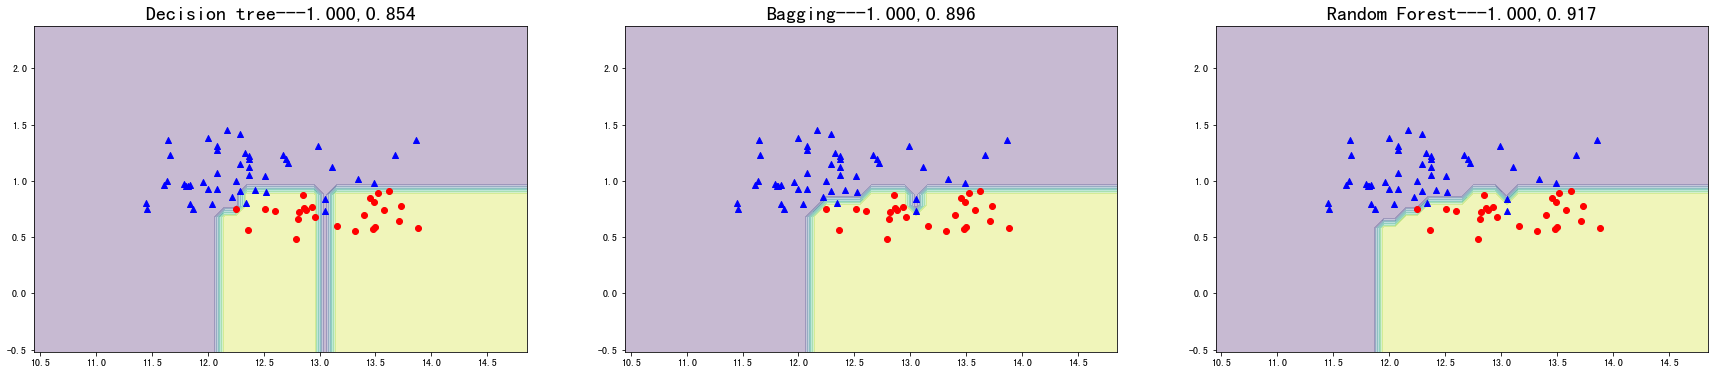

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier
from sklearn.metrics import accuracy_score
import numpy as np
from matplotlib import pyplot as plt
import os

data_path = os.path.join("data")
df_wine = pd.read_csv(os.path.join(data_path, "wine.data"), header=None)
df_wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins', 'Color intensity', 'Hue', 'OD280/OD315 of diluted wines', 'Proline']
df_wine = df_wine[df_wine['Class label'] != 1] # 数据集中有3个类别，这里我们只用其中的2个类别
y = df_wine['Class label'].values
X = df_wine[['Alcohol', 'Hue']].values # 为了可视化的目的，我们只选择2个特征

le = LabelEncoder()
y = le.fit_transform(y) # 把label转换为0和1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.40,  random_state=1) # 拆分训练集的40%作为测试集

tree = DecisionTreeClassifier(criterion='entropy', max_depth=None)
# 生成500个决策树，详细的参数建议参考官方文档
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, n_jobs=1, random_state=1)

rf = RandomForestClassifier(n_estimators=1000, criterion='gini', max_features='sqrt', max_depth=None, min_samples_split=2, bootstrap=True, n_jobs=1, random_state=1)

# 度量单个决策树的准确性
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)

# 度量bagging分类器的准确性
bag = bag.fit(X_train, y_train)
y_train_pred = bag.predict(X_train)
y_test_pred = bag.predict(X_test)
bag_train = accuracy_score(y_train, y_train_pred)
bag_test = accuracy_score(y_test, y_test_pred)

rf = rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
rf_train = accuracy_score(y_train, y_train_pred)
rf_test = accuracy_score(y_test, y_test_pred)

x_min = X_train[:, 0].min() - 1
x_max = X_train[:, 0].max() + 1
y_min = X_train[:, 1].min() - 1
y_max = X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

plt.figure(figsize=(30,6), facecolor='w')
for idx, clf, tt, score in zip([0, 1, 2], [tree, bag, rf], ['Decision tree', 'Bagging', 'Random Forest'],
                               [[tree_train,tree_test],[bag_train,bag_test],[rf_train, rf_test]]):
    clf.fit(X_train, y_train)
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.subplot(1, 3, idx+1)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plt.scatter(X_train[y_train==0, 0], X_train[y_train==0, 1], c='blue', marker='^')
    plt.scatter(X_train[y_train==1, 0], X_train[y_train==1, 1], c='red', marker='o')
    plt.title('%s---%.3f,%.3f' % (tt, score[0], score[1]),fontsize=20)